In [2]:
# prelude
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# -----------------------------------------------------------------------------
from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618                    # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold
k_random_state  = 0

# getaround project - threshold

# <span style="color:red"><b>TODO & Ideas - TO BE COMMENTED</b></span>

* ~~create figures with powerpoint to illustrate~~
* replace ``delay_at_checkout_in_minutes`` with slices of 5, 15, 30 and 60... minutes of delay 
    * the idea is to simplify the analysis 
    * then remove ``delay_at_checkout_in_minutes`` ? 
    * use the length of the slice as an hyperparameter and see how it helps to fight overfit ?

# Specifications (summary)

## Original
* https://app.jedha.co/course/project-deployment-ft/getaround-analysis-ft


## Summary


|field name	                                  |  Comment        |
|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|
|rental_id	                                  |  Unique identifier of the rental|
|car_id	                                      |  Unique identifier of the car |
|checkin_type	                              |  Flow used for both checkin and checkout. (ie. access and return the car) <br> mobile = rental agreement signed on the owner's smartphone <br> connect = car equiped with the Connect technology , opened by the driver with his smartphone <br> Note: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case |
|state	                                      |  canceled means that the rental did not happen (was canceled by the driver or the owner).
|delay_at_checkout_in_minutes	              |  Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
|previous_ended_rental_id	                  |  id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
|time_delta_with_previous_rental_in_minutes	  |  Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)


### Questions from the product manager : 

* How often are drivers late for the next check-in? How does it impact the next driver?
* How many rentals would be affected by the feature depending on the threshold and scope we choose?
* How many problematic cases will it solve depending on the chosen threshold and scope?
* Which share of our owner’s revenue would potentially be affected by the feature?

# EDA (Delay Analysis)

In [3]:
# -----------------------------------------------------------------------------
def remove_Outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # TODO try this : df = df[~((df['price'] < (Q1–1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df


# -----------------------------------------------------------------------------
# Remove outliers using z-score
# TODO : try this instead (smarter)
# from scipy import stats
# df = df[(np.abs(stats.zscore(df[['price']])) < 3)]

def remove_Outliers_Sigma(df, column):
    mean_col = df[column].mean()
    sigma_col = df[column].std()

    lower_bound = mean_col - 3 * sigma_col
    upper_bound = mean_col + 3 * sigma_col
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df

# -----------------------------------------------------------------------------
# method = "IQR" or "sigma"
def remove_Outliers(df, column, method="sigma"):
    match method:
        case "IQR":
            df = remove_Outliers_IQR(df, column)
        case "sigma":
            df = remove_Outliers_Sigma(df, column)
        case _:
            raise Exception("method must be IQR or sigma")    
    
    return df

# print(df.shape)
# for col in col_outliers:
#     df = remove_Outliers(df, col, method="sigma")
# print(df.shape)

In [4]:
# df = pd.read_excel('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx')
df = pd.read_excel(k_Current_dir/k_AssetsDir/"get_around_delay_analysis.xlsx", sheet_name="rentals_data")

print(f"\n\nPreview of the dataset :")
display(df.sample(15))



Preview of the dataset :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,Unnamed: 7
18929,531503,176670,connect,canceled,NaN,NaN,NaN,NaN
17365,532911,406609,mobile,canceled,NaN,NaN,NaN,NaN
7977,544313,406310,mobile,ended,11.0,NaN,NaN,NaN
2513,538762,369447,connect,ended,122.0,NaN,NaN,NaN
10267,551572,308620,mobile,ended,-7.0,NaN,NaN,NaN
19311,559257,398849,mobile,ended,NaN,NaN,NaN,NaN
12963,547549,315752,mobile,ended,-52.0,NaN,NaN,NaN
20636,554771,401785,mobile,ended,NaN,NaN,NaN,NaN
9847,565274,371841,mobile,ended,-3.0,NaN,NaN,NaN
14901,558774,391334,mobile,ended,-140.0,NaN,NaN,NaN


## Missing values

In [5]:
# print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))


rental_id                                      0.00
car_id                                         0.00
checkin_type                                   0.00
state                                          0.00
delay_at_checkout_in_minutes                  23.29
previous_ended_rental_id                      91.36
time_delta_with_previous_rental_in_minutes    91.36
Unnamed: 7                                    99.66
dtype: float64

### <span style="color:orange"><b>Comments :</b></span>
* `previous_ended_rental_id` and `time_delta_with_previous_rental_in_minutes` have the same amount of data
    * Indeed, `time_delta_with_previous_rental_in_minutes` exists, if and only if, there is a rental before the current one (``previous_ended_rental_id``) 
* More than 90% of the rentals are non-consecutive, either occurring more than 12 hours after the previous rental or having no direct follow-up
* The last column can be dropped 


In [6]:
# -----------------------------------------------------------------------------
def preprocessor(df):
    # drop
    df.drop(columns="Unnamed: 7", inplace=True)
    df.drop_duplicates(inplace=True)

    # format 
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    # rename
    # df.rename(
    #     columns={
    #         "rental_id": "id", 
    #         "previous_ended_rental_id": "previous_id"
    #     }, 
    #     inplace=True
    # )
                  
    # cast 
    df['rental_id'] = df['rental_id'].astype(str)
    df['car_id'] = df['car_id'].astype(str)
    # df['previous_ended_rental_id'] = df['previous_ended_rental_id'].astype(str)
    df['previous_ended_rental_id'] = df['previous_ended_rental_id'].apply(lambda x: str(int(x)) if not pd.isna(x) else x)

    # other preprocessing should come here
        # df["time_slot"] = (df["hour"]*60 + df["minute"])//k_time_slot_len
    
        # set index
        # df.set_index('id', inplace=True)


    return df

In [7]:
df = preprocessor(df)
print(f"\n\nPreview of the preprocessed dataset :")
# display(df.head())
display(df.sample(15))



Preview of the preprocessed dataset :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
19323,542112,405023,mobile,ended,NaN,NaN,NaN
2542,547251,256840,mobile,ended,121.0,NaN,NaN
5977,562152,373731,mobile,ended,32.0,NaN,NaN
13403,562511,353781,mobile,ended,-64.0,NaN,NaN
1708,565157,265528,mobile,ended,185.0,NaN,NaN
11590,540850,393078,mobile,ended,-24.0,NaN,NaN
6058,565250,310404,mobile,ended,31.0,NaN,NaN
3858,545177,390509,connect,ended,72.0,542725,720.0
18147,564968,401664,mobile,canceled,NaN,NaN,NaN
18811,535511,388286,mobile,ended,NaN,NaN,NaN


Browsing the dataset we found one weird value in `delay_at_checkout_in_minutes` when :
* ``state`` = canceled
* ``previous_ended_rental_id`` = NaN

See below


In [8]:
df[(df['state']=="canceled") & (df['previous_ended_rental_id'].isna())]

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
16344,559126,379544,mobile,canceled,-17468.0,NaN,NaN
16672,505000,363965,mobile,canceled,NaN,NaN,NaN
16673,508865,299063,connect,canceled,NaN,NaN,NaN
16675,512475,322502,mobile,canceled,NaN,NaN,NaN
16676,513743,330658,mobile,canceled,NaN,NaN,NaN
...,...,...,...,...,...,...,...
21303,569325,345079,mobile,canceled,NaN,NaN,NaN
21304,569764,405347,mobile,canceled,NaN,NaN,NaN
21305,570001,386413,connect,canceled,NaN,NaN,NaN
21307,571481,311841,mobile,canceled,NaN,NaN,NaN


* Since a ``canceled`` bookings with no previous rental (``previous_ended_rental_id`` = Nan) cannot be returned in advance (``delay_at_checkout_in_minutes`` = -17468) this must be a typo
* Let's correct it

In [9]:
df.at[16344, "delay_at_checkout_in_minutes"] = np.nan
df[(df['state']=="canceled") & (df['previous_ended_rental_id'].isna())]

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
16344,559126,379544,mobile,canceled,NaN,NaN,NaN
16672,505000,363965,mobile,canceled,NaN,NaN,NaN
16673,508865,299063,connect,canceled,NaN,NaN,NaN
16675,512475,322502,mobile,canceled,NaN,NaN,NaN
16676,513743,330658,mobile,canceled,NaN,NaN,NaN
...,...,...,...,...,...,...,...
21303,569325,345079,mobile,canceled,NaN,NaN,NaN
21304,569764,405347,mobile,canceled,NaN,NaN,NaN
21305,570001,386413,connect,canceled,NaN,NaN,NaN
21307,571481,311841,mobile,canceled,NaN,NaN,NaN


## Data overview

In [10]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "mean" : Mean value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if col_dtype != "object":
            max_of_col  = df[col_name].max()
            min_of_col  = df[col_name].min()
            mean_of_col = df[col_name].mean()
            outlier_hi  = df[col_name].mean() + 3*df[col_name].std()
            outlier_lo  = df[col_name].mean() - 3*df[col_name].std()
        else:
            max_of_col = -1
            min_of_col =  1
            mean_of_col = np.nan
            outlier_hi = -1
            outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2) ,
            "min"                 : round(min_of_col,2),
            "mean"                : round(mean_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [11]:
print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   



The dataset consists of :
	        2 dimensions
	   21_310 observations
	        7 features    


% of data type :


,types,as_%
object,5,71.43
float64,2,28.57




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,mean,max,+3*sig,distinct val count
5,previous_ended_rental_id,object,19469,91.36,1841,1788,1.00,1.0,NaN,-1.0,-1.00,"{'537243': 4, '547969': 3, '541079': 3, '54657..."
6,time_delta_with_previous_rental_in_minutes,float64,19469,91.36,1841,25,-484.50,0.0,279.29,720.0,1043.07,"{0.0: 279, 60.0: 183, 120.0: 137, 720.0: 130, ..."
4,delay_at_checkout_in_minutes,float64,4965,23.30,16345,1744,-2918.75,-22433.0,60.77,71084.0,3040.29,"{4.0: 165, 6.0: 152, 2.0: 151, 7.0: 150, 9.0: ..."
0,rental_id,object,0,0.00,21310,21310,1.00,1.0,NaN,-1.0,-1.00,"{'532240': 1, '522106': 1, '568794': 1, '53869..."
1,car_id,object,0,0.00,21310,8143,1.00,1.0,NaN,-1.0,-1.00,"{'334190': 33, '241021': 29, '392479': 29, '34..."
2,checkin_type,object,0,0.00,21310,2,1.00,1.0,NaN,-1.0,-1.00,"{'mobile': 17003, 'connect': 4307}"
3,state,object,0,0.00,21310,2,1.00,1.0,NaN,-1.0,-1.00,"{'ended': 18045, 'canceled': 3265}"


### <span style="color:orange"><b>Comments :</b></span>
* Only 2 values for ``checkin_type`` (mobile, connect) and ``state`` (ended, canceled) 
* There are "only" 25 uniques value in `time_delta_with_previous_rental_in_minutes` 
* Again, `previous_ended_rental_id` and `time_delta_with_previous_rental_in_minutes` have the same amount of data
* Outliers in ``delay_at_checkout_in_minutes`` (max > 3 $\sigma$)

## About checkin_type

Nb mobile  :  17_003
Nb connect :   4_307


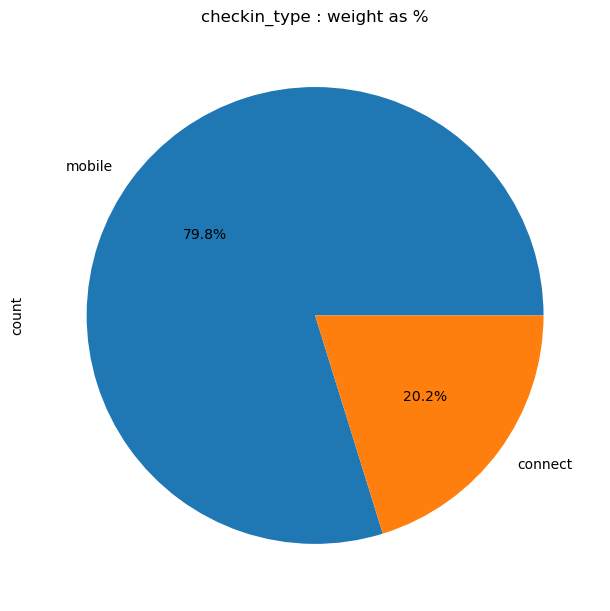

In [12]:
counts = df["checkin_type"].value_counts()
print(f"Nb mobile  : {counts['mobile']:>7_}")
print(f"Nb connect : {counts['connect']:>7_}")

_ = counts.plot.pie(title="checkin_type : weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* 20% of the checkin/checkout are made via connected cars  


## About state 

Nb ended    :  18_045
Nb canceled :   3_265


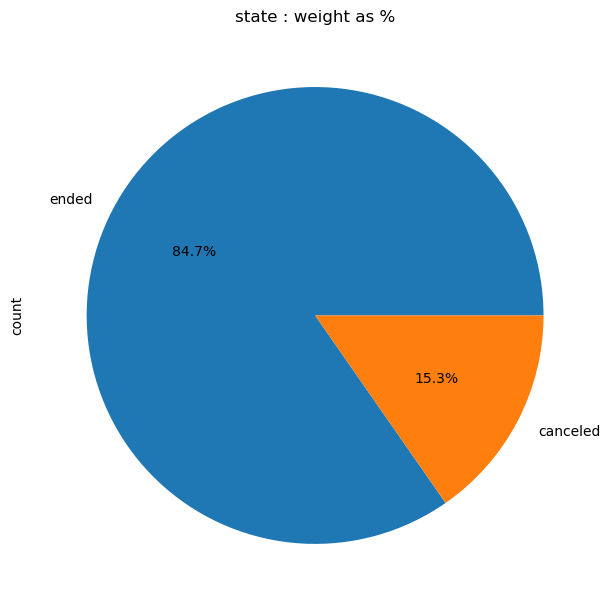

In [13]:
counts = df["state"].value_counts()
print(f"Nb ended    : {counts['ended']:>7_}")
print(f"Nb canceled : {counts['canceled']:>7_}")

_ = counts.plot.pie(title="state : weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

In [14]:
display(df[df["state"]=="canceled"].sample(15))

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
18662,550495,396409,mobile,canceled,NaN,NaN,NaN
17632,541251,407334,mobile,canceled,NaN,NaN,NaN
17102,541867,302561,connect,canceled,NaN,NaN,NaN
19457,537593,380371,mobile,canceled,NaN,NaN,NaN
20174,545522,349142,mobile,canceled,NaN,NaN,NaN
18631,535122,305396,mobile,canceled,NaN,NaN,NaN
20780,565218,415060,mobile,canceled,NaN,NaN,NaN
16962,540530,404070,mobile,canceled,NaN,NaN,NaN
19290,574715,256777,mobile,canceled,NaN,NaN,NaN
21277,564316,411979,mobile,canceled,NaN,NaN,NaN


### <span style="color:orange"><b>Comments :</b></span>
* 15% of the rentals are canceled
* Obviously, in these cases, there is no ``delay_at_checkout_in_minutes`` 
* When there is a rental before the one canceled (`previous_ended_rental_id` != NaN), then a `time_delta_with_previous_rental_in_minutes` also exists 


## About state & consecutive rentals

In [15]:
df_tmp = df[["state", "previous_ended_rental_id"]].copy()
df_tmp.rename(
    columns={
        "previous_ended_rental_id": "booking", 
    }, 
    inplace=True
)

df_tmp.loc[pd.notna(df_tmp["booking"]), "booking"] = "consecutive"
df_tmp["booking"].fillna("not consecutive", inplace=True)
# display(df_tmp.sample(15))

df_pivot = df_tmp.pivot_table(index='state', columns='booking', aggfunc=len, margins=True, margins_name='Total')
display(df_pivot)

# df_pivot = df_tmp.pivot_table(index='booking', columns='state', aggfunc=len, margins=True, margins_name='Total')
# display(df_pivot)


booking,consecutive,not consecutive,Total
state,,,
canceled,229,3036,3265
ended,1612,16433,18045
Total,1841,19469,21310


### <span style="color:orange"><b>Comments :</b></span>

* Out of 1_841 consecutive bookings, 229 are canceled. 
    * This might suggest that in these 229 cases, the previous driver was so late that the current had to cancel his booking.

The table also confirms that :
* The vast majority 91.36% ($\frac{19469}{21310}$) of the bookings are not consecutive (or are spaced by more than 12 hours)
    * This is what we said in the "Missing values" section
* 84.67% ($\frac{18045}{21310}$) of the bookings are not canceled
    * This is what we said in the "About state" section (see the last pie chart)




## About state, consecutive rentals and late returns

In [16]:

# DONE : faut être plus fin que ça. 
# Dans les consecutifs on considère late ssi `delay_at_checkout_in_minutes` is strictly greater than ``time_delta_with_previous_rental_in_minutes``
# Faut faire apparaitre 270
# voir plus bas

def classify_value(row):
    value = row["return"]
    if row["booking"] == "consecutive":
        if value <= row["delta"]:
            return "On time"
        elif value > row["delta"]:
            return "Late"
        else:
            return "No Data"
    elif row["booking"] == "not consecutive":
        if value <= 0:
            return "On time"
        elif value > 0:
            return "Late"
        else:
            return "No Data"
    else:
        raise ValueError("Unexpected booking value")


df_tmp = df[["state", "previous_ended_rental_id", "delay_at_checkout_in_minutes", "time_delta_with_previous_rental_in_minutes"]].copy()
df_tmp.rename(
    columns={
        "previous_ended_rental_id"     : "booking", 
        "delay_at_checkout_in_minutes" : "return",
        "time_delta_with_previous_rental_in_minutes" : "delta",
    }, 
    inplace=True
)
# display(df_tmp.sample(15))
# display(df_tmp.head(15))

# df_tmp.loc[pd.notna(df_tmp["booking"]), "booking"] = "consecutive"
# df_tmp["booking"].fillna("not consecutive", inplace=True)
df_tmp["booking"] = np.where(pd.notna(df_tmp["booking"]), "consecutive", "not consecutive")
# display(df_tmp.head(15))

# convert to string first then replace with meaningful value
df_tmp["return"] = pd.to_numeric(df_tmp["return"], errors='coerce')
# df_tmp["return"] = df_tmp["return"].astype(str)
df_tmp['return'] = df_tmp.apply(classify_value, axis=1)




# # df_pivot = df_tmp.pivot_table(index=['booking', "return"], columns='state', aggfunc=len, margins=True, margins_name='Total')
# # display(df_pivot)


# df_pivot = df_tmp.pivot_table(index='state', columns=['booking', "return"], aggfunc=len, margins=True, margins_name='Total')
df_pivot = df_tmp.pivot_table(index='state', columns=['booking', "return"], aggfunc=len)
df_pivot['Total'] = df_pivot.sum(axis=1, skipna=True)
df_pivot.loc['Total'] = df_pivot.sum(axis=0, skipna=True)
display(df_pivot)


delta                                                    Total
booking  consecutive                 not consecutive                         
return          Late No Data On time            Late No Data On time         
state                                                                        
canceled         NaN   229.0     NaN             NaN  3036.0     NaN   3265.0
ended          270.0    97.0  1245.0          8602.0  1603.0  6228.0  18045.0
Total          270.0   326.0  1245.0          8602.0  4639.0  6228.0  21310.0

### <span style="color:orange"><b>Comments :</b></span>

Compared to the previous table we now have more information about the bookings which are not canceled
* When 2 bookings are consecutive with a Time $\Delta$ between them most of the rentals are on time (returns happen before `time_delta_with_previous_rental_in_minutes`)
    * See 270 vs 1245
* When there is no Time $\Delta$ (no previous driver) most of the returns are late
    * See 8602 vs 6228

## About time_delta_with_previous_rental_in_minutes

In [17]:
print("Unique values in time_delta_with_previous_rental_in_minutes : ")
display(sorted(df["time_delta_with_previous_rental_in_minutes"].unique()))

Unique values in time_delta_with_previous_rental_in_minutes : 


[nan,
 0.0,
 30.0,
 60.0,
 90.0,
 120.0,
 150.0,
 180.0,
 210.0,
 240.0,
 270.0,
 300.0,
 330.0,
 360.0,
 390.0,
 420.0,
 450.0,
 480.0,
 510.0,
 540.0,
 570.0,
 600.0,
 630.0,
 660.0,
 690.0,
 720.0]

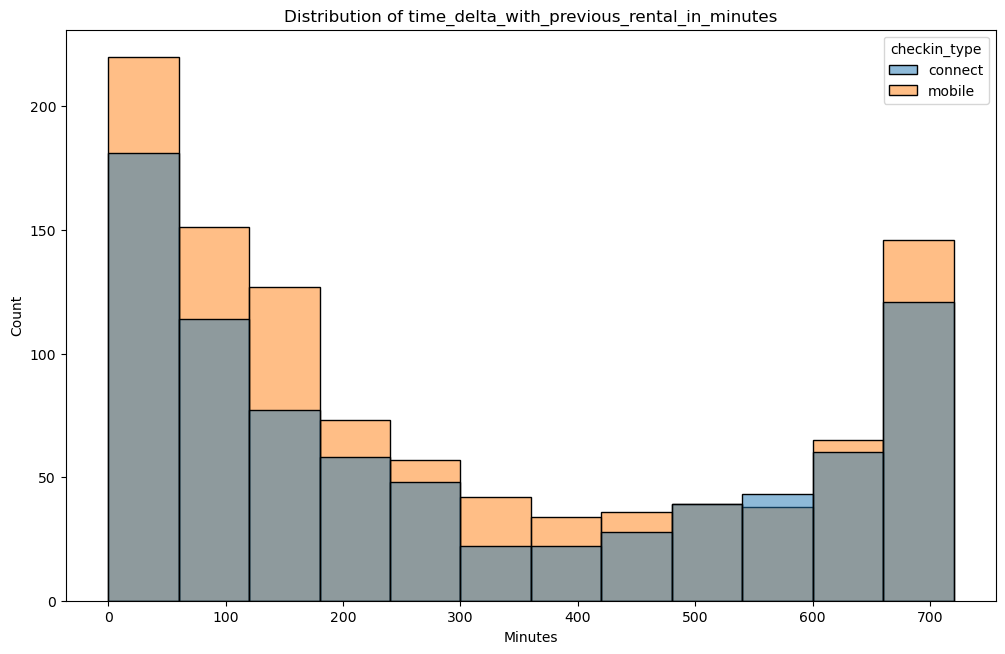

In [18]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.histplot(data=df, x="time_delta_with_previous_rental_in_minutes", hue="checkin_type", hue_order = ["connect", "mobile"]) #, bins=100, , kde=True

ax.set_title("Distribution of time_delta_with_previous_rental_in_minutes")
ax.set_xlabel("Minutes")
plt.show()

### <span style="color:orange"><b>Comments :</b></span>

* Surprisingly, no matter the `checkin_type`, the number of Time $\Delta$ do not decrease when its values become extreme
* The count of Time $\Delta$ close to 12H (720 min.) is similar to the number of Time $\Delta$ close to 2H (120 min.)
* <span style="color:orange"><b>For action :</b></span> get a better understanding on how the Time $\Delta$ is set
    * Is it set per rental after discussing with the driver?
    * When the leasers set the Time $\Delta$ to 12H, are they willing to use the car between 2 rentals?
    * ...


## About delay_at_checkout_in_minutes

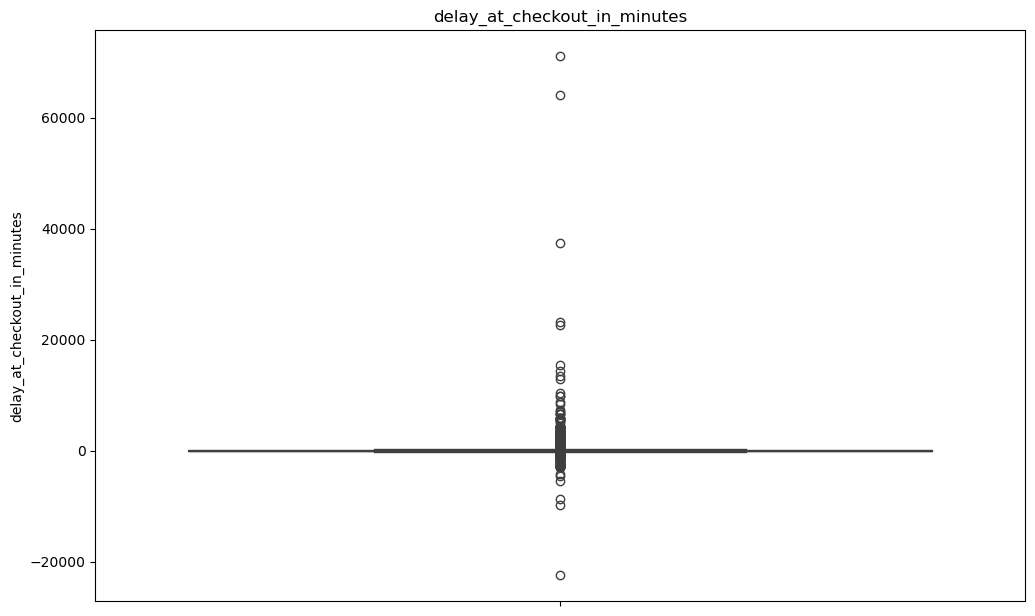

In [19]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.boxplot(df, y="delay_at_checkout_in_minutes", legend=False)                  #palette=palette_gender, hue="gender" ,  
plt.title("delay_at_checkout_in_minutes")
plt.show()

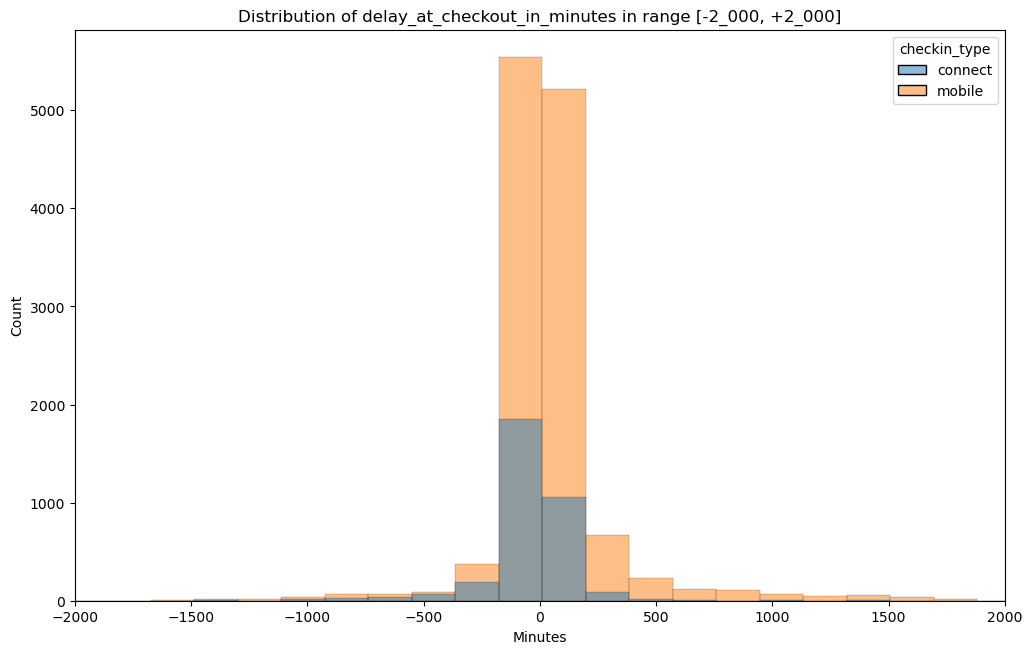

In [20]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.histplot(data=df, x="delay_at_checkout_in_minutes", hue="checkin_type", hue_order = ["connect", "mobile"], bins=500) #, bins=100, , kde=True

ax.set_title("Distribution of delay_at_checkout_in_minutes in range [-2_000, +2_000]")
ax.set_xlabel("Minutes")
ax.set_xlim(-2000, 2000)
plt.show()

# How often are drivers late for the next check-in? How does it impact the next driver?

### <span style="color:orange"><b>Comments :</b></span>

The figure below explains how it works :

<p align="center">
<img src="./assets/no_treshold.png" alt="drawing" width="800"/>
<p> 

There are two cases, depending on whether there is a previous rental or not :
1. No previous driver (top of the figure, blue)
    * Cars are supposed to be returned before **Checkout**  
    * If not, we call **Delay** (``delay_at_checkout_in_minutes``) the period of time between the **Checkout** and the **Return Time**
        * The car is considered as returned late
1. There is a previous driver (bottom of the figure, orange)
    * The owner of the car set a **Time $\Delta$** between the 2 consecutive bookings
    * Length of the **Time $\Delta$** ranges from 0 to 720 min. by steps of 30 min.
    * The **Time $\Delta$** period of time act as a shock absorber if the previous customer is late returning the car
        * The owner may rent his car less often, but in return, he protects himself from late returns
        * This avoids a certain amount of friction with unhappy 'next driver'
    * Cars are supposed to be returned before **Checkout** + **Time $\Delta$**
    * If not the car is considered as returned late
        * The next booking is problematic and it can be canceled


<!-- **IMPORTANT :**

We consider that the next driver is be impacted if :
1. The transaction is in state `ended` but the return of the car happens after **Checkout** + **Time $\Delta$** 
1. The current transaction is in state ``canceled`` while `previous_ended_rental_id` exists. 
    * We can assume that the transaction is cancelled precisely because the previous driver is late. -->

    

## How often are drivers late for the next check-in?

We consider a driver is late when :
1. The transactions is in state `ended`, there is no previous driver (``previous_ended_rental_id`` = Nan) and `delay_at_checkout_in_minutes` is strictly greater than 0 
    * According the last pivot table we know this number is 8602
1. The transactions is in state `ended`, there is previous driver (``previous_ended_rental_id`` != Nan) and `delay_at_checkout_in_minutes` is strictly greater than ``time_delta_with_previous_rental_in_minutes``
    * According the last pivot table we know this number is 270
1. The transactions in state `canceled` AND there is a `previous_ended_rental_id` 
    * Again, in this case we can assume that the transaction is cancelled precisely because the previous driver is late.
    * However, we don't know precisely how long after the planned Checkout, the previous driver returned the car
    * According the last pivot table we know this number is 229

* We then compare this number to the total number of returns (in advance or late). 
    * We do not take into account returns for wich we do have the `delay_at_checkout_in_minutes`

In [21]:
# df_tmp = df[(df['state']=="ended") & (df['previous_ended_rental_id'].isna()) & (df['delay_at_checkout_in_minutes']>0)].copy()
# display(df_tmp.sample(15))
# len(df_tmp)
late1 = len(df[(df['state']=="ended") & (df['previous_ended_rental_id'].isna()) & (df['delay_at_checkout_in_minutes']>0)])
print(late1)

# df_tmp2 = df[(df['state']=="ended") & (df['previous_ended_rental_id'].notna()) & (df['delay_at_checkout_in_minutes']>df['time_delta_with_previous_rental_in_minutes'])].copy()
# display(df_tmp2.sample(15))
# len(df_tmp2)
late2 = len(df[(df['state']=="ended") & (df['previous_ended_rental_id'].notna()) & (df['delay_at_checkout_in_minutes']>df['time_delta_with_previous_rental_in_minutes'])]) 
print(late2)

# df_tmp3 = df[(df['state']=="canceled") & (df['previous_ended_rental_id'].notna()) ].copy()
# display(df_tmp3.sample(15))
# len(df_tmp3)
late3 = len(df[(df['state']=="canceled") & (df['previous_ended_rental_id'].notna())])
print(late3)

# We must add late3 !
total_number_returns = len(df[(df['delay_at_checkout_in_minutes'].notna())]) + late3
print(total_number_returns)
percent_late_return = (late1 + late2 + late3)/total_number_returns * 100

print(f"The percentage of late returns = {percent_late_return:.2f}%")



8602
270
229
16574
The percentage of late returns = 54.91%


### <span style="color:orange"><b>Comments :</b></span>

* 55% of the returns are late



## Can we analyze late rental returns more accurately?

* Until now, to analyze delays, we have taken into account:
    * 8 602 late returns that occur after Checkout
    * 270 late returns that occur after Time $\Delta$
    * 229 rentals that are canceled precisely because the vehicle is not returned on time
* That said, for these 229 cases, we do not have information about the exact time when the vehicle was eventually returned.
* Moreover, when comparing these 229 cases to the total number of late returns, they only represent 2.5% ($\frac{229}{229+8602+270}$).

<span style="color:orange"><b>Decision :</b></span> To better analyze late returns, below we focus on analyzing the delays from rentals that are not canceled.

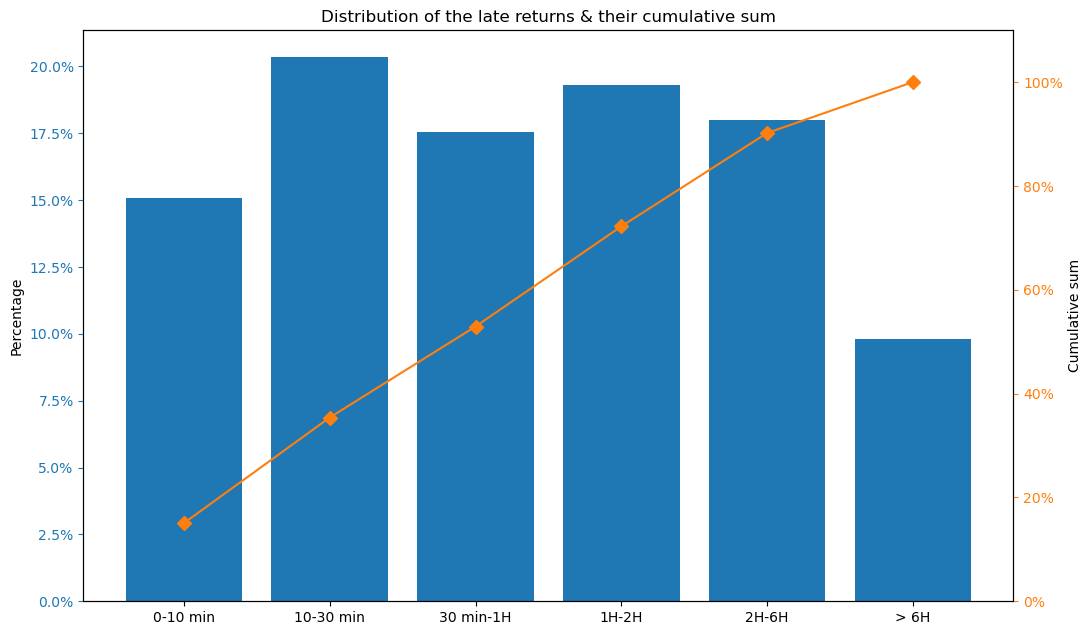

In [22]:
# compute the content of the column actual_delay
# actual_delay = delay_at_checkout_in_minutes                   if there is no time_delta_with_previous_rental_in_minutes
# actual_delay = delay_at_checkout_in_minutes - time_delta      if there is a time_delta_with_previous_rental_in_minutes
# uncomment the display() if needed
# if the value in actual_content is positive this mean the return is late, no matter if there is a time delta or not
def calculate_actual_delay(row):
    if not np.isnan(row['delay_at_checkout_in_minutes']) and not np.isnan(row['time_delta_with_previous_rental_in_minutes']):
        return row['delay_at_checkout_in_minutes'] - row['time_delta_with_previous_rental_in_minutes']
    elif np.isnan(row['time_delta_with_previous_rental_in_minutes']) and not np.isnan(row['delay_at_checkout_in_minutes']):
        return row['delay_at_checkout_in_minutes']
    else:
        return np.nan

df_tmp = df[df['state']=="ended"].copy()
# display(df_tmp.sample(15))

df_tmp["actual_delay"] = df.apply(calculate_actual_delay, axis=1)
# display(df_tmp.sample(15))

labels_in_order = ['0-10 min', '10-30 min', '30 min-1H', '1H-2H', '2H-6H', '> 6H']

categories = pd.cut(
    df_tmp['actual_delay'], 
    bins=[0, 10, 30, 60, 120, 360, float('inf')],
    labels = labels_in_order
)
df_tmp['cat_delay'] = categories
# display(df_tmp.sample(15))

df_tmp2 = pd.DataFrame(round(df_tmp['cat_delay'].value_counts()/len(df_tmp[df_tmp["actual_delay"]>0])*100, 2)).reset_index()
df_tmp2.columns = ['cat_delay', 'delay_%']

df_tmp2['cat_delay'] = pd.Categorical(df_tmp2['cat_delay'], categories=labels_in_order, ordered=True)
df_tmp2.sort_values('cat_delay', inplace=True)
df_tmp2.set_index('cat_delay', inplace=True)
# print(df_tmp2)

df_tmp2["cum_percent"] = df_tmp2["delay_%"].cumsum()/df_tmp2["delay_%"].sum()*100

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp2.index, df_tmp2["delay_%"], color="C0")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Percentage')
ax.tick_params(axis="y", colors="C0")
ax.set_title("Distribution of the late returns & their cumulative sum")

ax2 = ax.twinx()
ax2.plot(df_tmp2.index, df_tmp2["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative sum')
ax2.set(ylim=(0, 110))
ax2.tick_params(axis="y", colors="C1")

plt.show()


### <span style="color:orange"><b>Comments :</b></span>
* More than 50% of the late returns are below 1H
* Almost 80% of the late returns are below 2H


## How does it impact the next driver?
 
<p align="center">
<img src="./assets/no_treshold.png" alt="drawing" width="800"/>
<p> 


This point have been already addressed

We consider as problematic the following kind of returns :
1. Cars returned after Checkout
    * Because the owner of the car can't use it  
1. Cars returned after Time $\Delta$
    * Because the next driver can't get the car
1. The number of bookings which are canceled because the previous driver is late

# How many rentals would be affected by the feature depending on the threshold and scope we choose?


<p align="center">
<img src="./assets/with_treshold.png" alt="drawing" width="800"/>
<p> 


* At this point, it is not clear in the specifications if the Threshold comes in addition to the Time $\Delta$, if it replace it...
* <span style="color:orange"><b>Decision :</b></span> until further notice, we'll assume that Threshold simply replaces Time Delta 
* The rentals taken into account are :
    * Cars returned after Treshold 
    * No matter if there is (or not) a previous driver
    * We compare `delay_at_checkout_in_minutes` vs Treshold
    * Canceled rentals cannot be taken into account because when there is a previous driver, we don't know pricely at what time the car is returned
* In order to calculate the impact, for different values of Treshold, we compare the previous number with the number of rentals that are ``ended`` and NOT on the whole dataset (``ended`` + ``canceled``)  
* The impact should be 100% when Treshold is 0 and 0% when Threshold is infinite


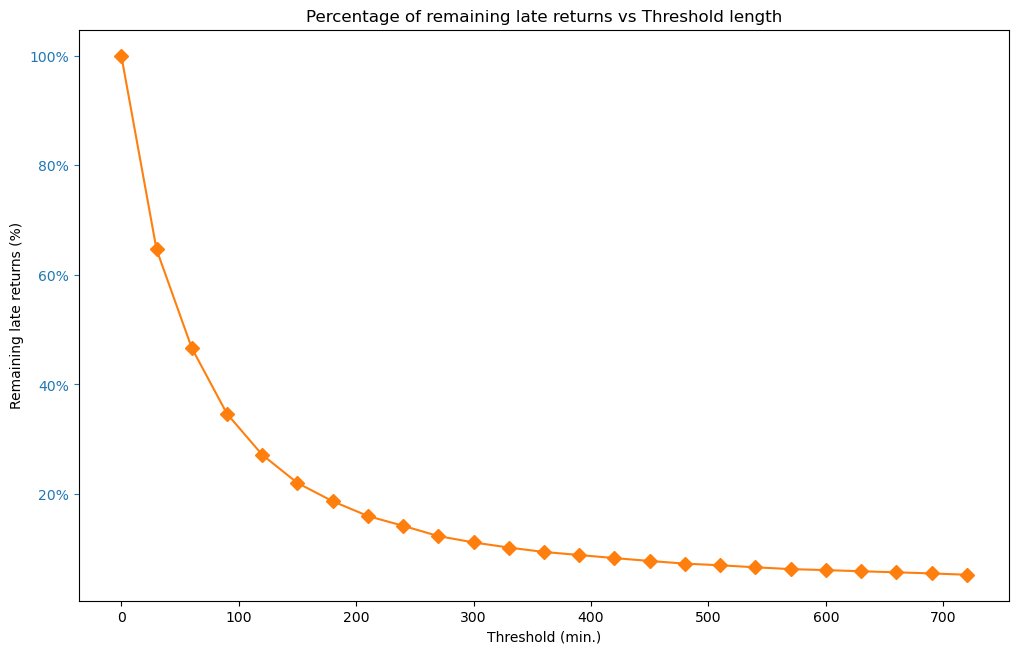

In [23]:
# see time_delta_with_previous_rental_in_minutes
thresholds = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720]

df_tmp = df[df['state']=="ended"].copy()

# number of reservations with delay_at_checkout_in_minutes > 0
nb_late = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0 )])
# print(nb_late)

rates=[]
for t in thresholds:
    # no matter if there is a previous_ended_rental_id or not
    # n is the number of bookings with a delay_at_checkout_in_minutes greater than current threshold (0...720)
    n = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > (t) )])
    rates.append(n/nb_late*100)
# display(rates)

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.plot(thresholds, rates, color="C1", marker="D", ms=7)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Remaining late returns (%)')
ax.set_xlabel("Threshold (min.)")
ax.tick_params(axis="y", colors="C0")
ax.set_title("Percentage of remaining late returns vs Threshold length")
plt.show()


### <span style="color:orange"><b>Comments :</b></span>
* Obviously 100% of the late returns are affected when Threshold is set to 0
* Around 50% of the late returns are concernd when Threshold is set to 60 min.


However, we need to evaluate the percentage of rentals which would be affected

* To do so we compare the number of returns above Treshold
* Versus the number of returns with delay information
    * On purpose, we do not take into account returns without information about `delay_at_checkout_in_minutes`

16345


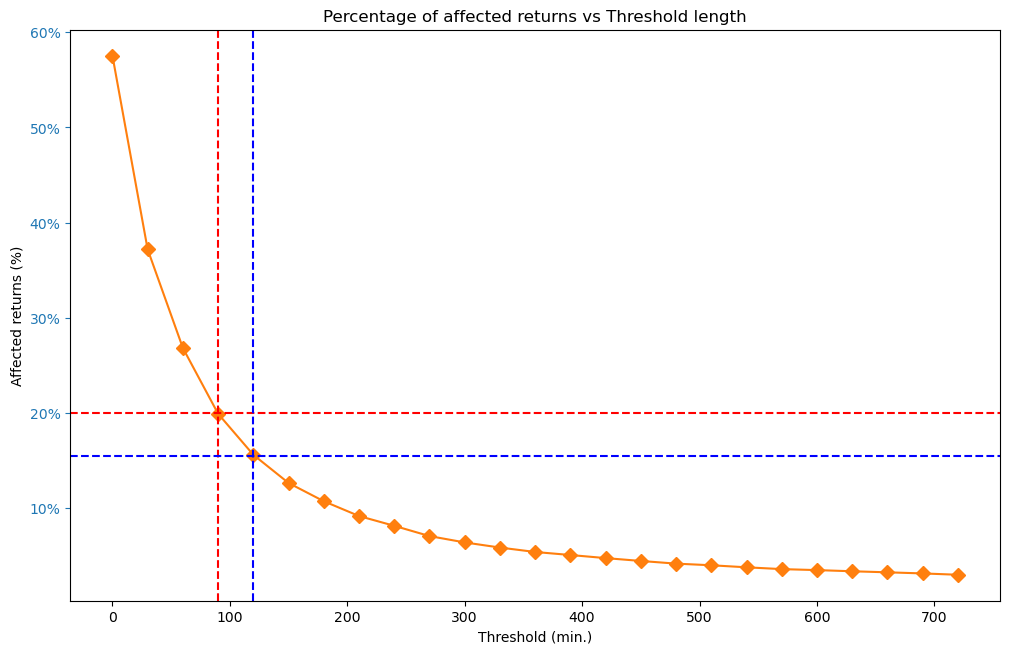

In [35]:
# see time_delta_with_previous_rental_in_minutes
thresholds = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720]

df_tmp = df[df['state']=="ended"].copy()

# number of reservations with delay_at_checkout_in_minutes > 0
# nb_late = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0 )])
# nb = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0 )])
# nb = len(df_tmp)
nb = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'].notna())])
print(nb)

rates=[]
for t in thresholds:
    # no matter if there is a previous_ended_rental_id or not
    # n is the number of bookings with a delay_at_checkout_in_minutes greater than current threshold (0...720)
    n = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > (t) )])
    rates.append(n/nb*100)
# display(rates)

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.plot(thresholds, rates, color="C1", marker="D", ms=7)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Affected returns (%)')
ax.set_xlabel("Threshold (min.)")
ax.tick_params(axis="y", colors="C0")
ax.set_title("Percentage of affected returns vs Threshold length")

# xv and yh are "hand adjusted" to cross at 20%
xv = 90
yh = 20                                         
plt.axvline(x=xv, color='red', linestyle='--')
plt.axhline(y=yh, color='red', linestyle='--')


# xv1 = 180
# yh1 = 10.7                                    
xv1 = 120
yh1 = 15.5                                    

plt.axvline(x=xv1, color='blue', linestyle='--')
plt.axhline(y=yh1, color='blue', linestyle='--')

plt.show()


### <span style="color:orange"><b>Comments :</b></span>
* If the threshold is set to 0 min., 57% of the returns will exceed the threshold, making 57% of the returns problematic
    * One could be surprised since, earlier, in section **How often are drivers late for the next check-in?** we said that 55% of the returns are late.
    * In fact here we cannot take into account the 229 canceled bookings because they don't have information about the time of return
* When the Threshold is set to 1H30 then 20% of the returns remains problematic


### What about "mobile" ?

12943


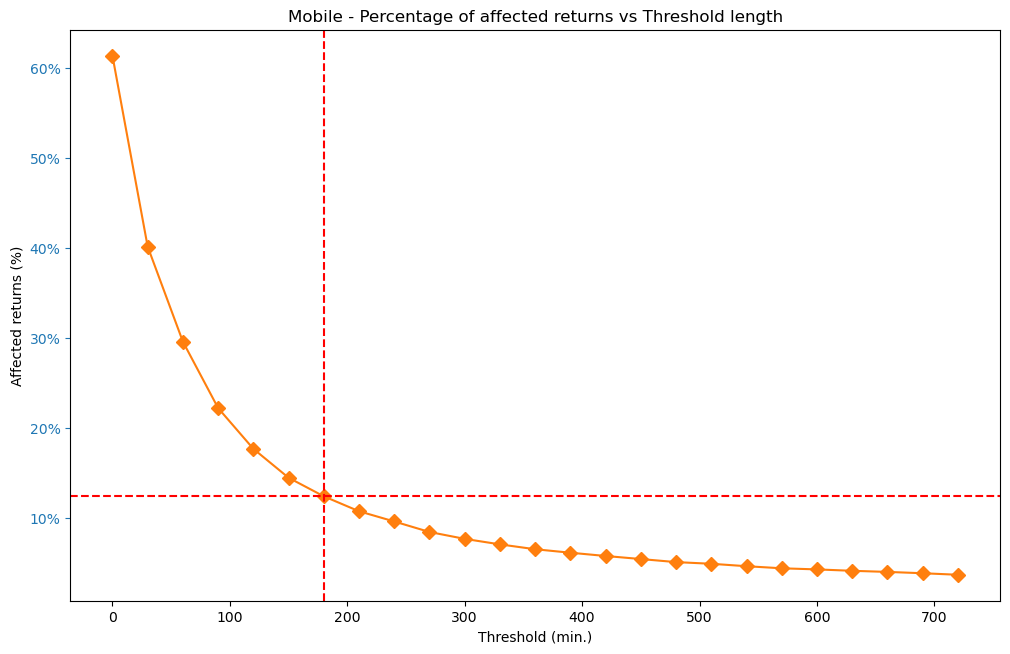

In [28]:
# see time_delta_with_previous_rental_in_minutes
thresholds = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720]

df_tmp = df[(df['state']=="ended") & ((df['checkin_type']=="mobile"))].copy()

# number of reservations with delay_at_checkout_in_minutes > 0
# nb_late = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0 )])
# nb = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0 )])
# nb = len(df_tmp)

nb = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'].notna())])
print(nb)

rates=[]
for t in thresholds:
    # no matter if there is a previous_ended_rental_id or not
    # n is the number of bookings with a delay_at_checkout_in_minutes greater than current threshold (0...720)
    n = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > (t) )])
    rates.append(n/nb*100)
# display(rates)

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.plot(thresholds, rates, color="C1", marker="D", ms=7)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Affected returns (%)')
ax.set_xlabel("Threshold (min.)")
ax.tick_params(axis="y", colors="C0")
ax.set_title("Mobile - Percentage of affected returns vs Threshold length")

# xv and yh are "hand adjusted" to cross at 20%
xv = 105
yh = 20                                         

plt.axvline(x=xv, color='red', linestyle='--')
plt.axhline(y=yh, color='red', linestyle='--')


plt.show()


### What about "connect" ?

3402


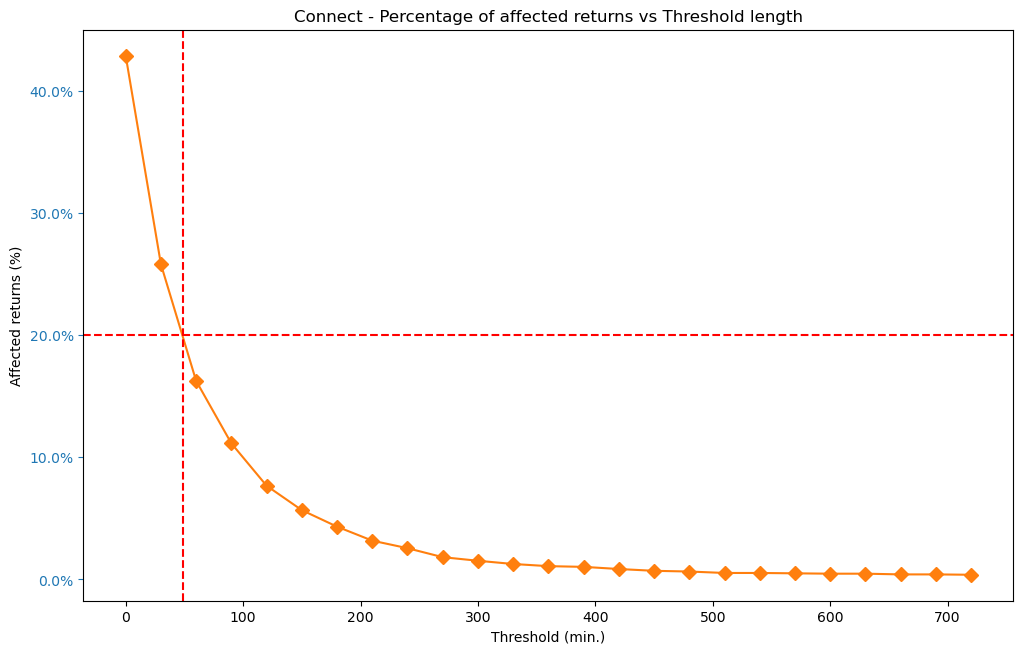

In [32]:
# see time_delta_with_previous_rental_in_minutes
thresholds = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720]

df_tmp = df[(df['state']=="ended") & ((df['checkin_type']=="connect"))].copy()

# number of reservations with delay_at_checkout_in_minutes > 0
# nb_late = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0 )])
# nb = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0 )])
# nb = len(df_tmp)

nb = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'].notna())])
print(nb)

rates=[]
for t in thresholds:
    # no matter if there is a previous_ended_rental_id or not
    # n is the number of bookings with a delay_at_checkout_in_minutes greater than current threshold (0...720)
    n = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > (t) )])
    rates.append(n/nb*100)
# display(rates)

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.plot(thresholds, rates, color="C1", marker="D", ms=7)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Affected returns (%)')
ax.set_xlabel("Threshold (min.)")
ax.tick_params(axis="y", colors="C0")
ax.set_title("Connect - Percentage of affected returns vs Threshold length")

# xv and yh are "hand adjusted" to cross at 20%
xv = 49
yh = 20                                         
plt.axvline(x=xv, color='red', linestyle='--')
plt.axhline(y=yh, color='red', linestyle='--')


plt.show()


# How many problematic cases will it solve depending on the chosen threshold and scope?

* The question has been already answered
* Using the previous graphs we can see :
    * Mobile : if threshold is set to 105 min, 20% returns remains problematic
    * Connect : if threshold is set to 49 min, 20% returns remains problematic  

<span style="color:orange"><b>Recommendation :</b></span> Set the Treshold to 2H globally and target 10 % of the problematic returns 


# Which share of our owner’s revenue would potentially be affected by the feature?

* No way to answer this question since both dataset cannot be joined

# <span style="color:red"><b>Scrap book - Please ignore</b></span>

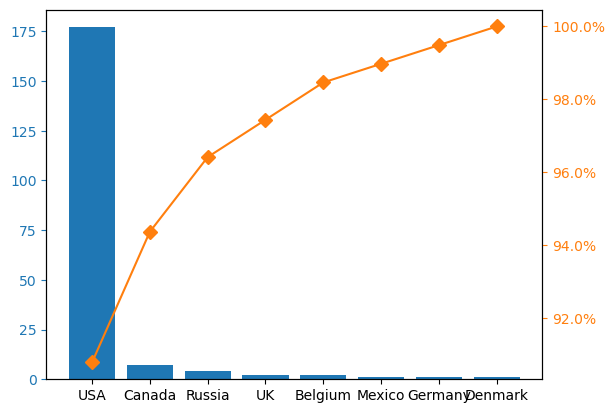

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

df = pd.DataFrame({'country': [177.0, 7.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0]})
df.index = ['USA', 'Canada', 'Russia', 'UK', 'Belgium', 'Mexico', 'Germany', 'Denmark']
df = df.sort_values(by='country',ascending=False)
df["cum_percent"] = df["country"].cumsum()/df["country"].sum()*100


fig, ax = plt.subplots()
ax.bar(df.index, df["country"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [27]:
import pandas as pd

df = pd.DataFrame({
    'couleurs': ['rouge', 'vert', 'bleu', 'rouge', 'bleu'],
    'valeurs': [10, 20, 30, 40, 50]
})

order = ['bleu', 'rouge', 'vert']

df['couleurs'] = pd.Categorical(df['couleurs'], categories=order, ordered=True)
df.sort_values('couleurs', inplace=True)
print(df)

  couleurs  valeurs
2     bleu       30
4     bleu       50
0    rouge       10
3    rouge       40
1     vert       20


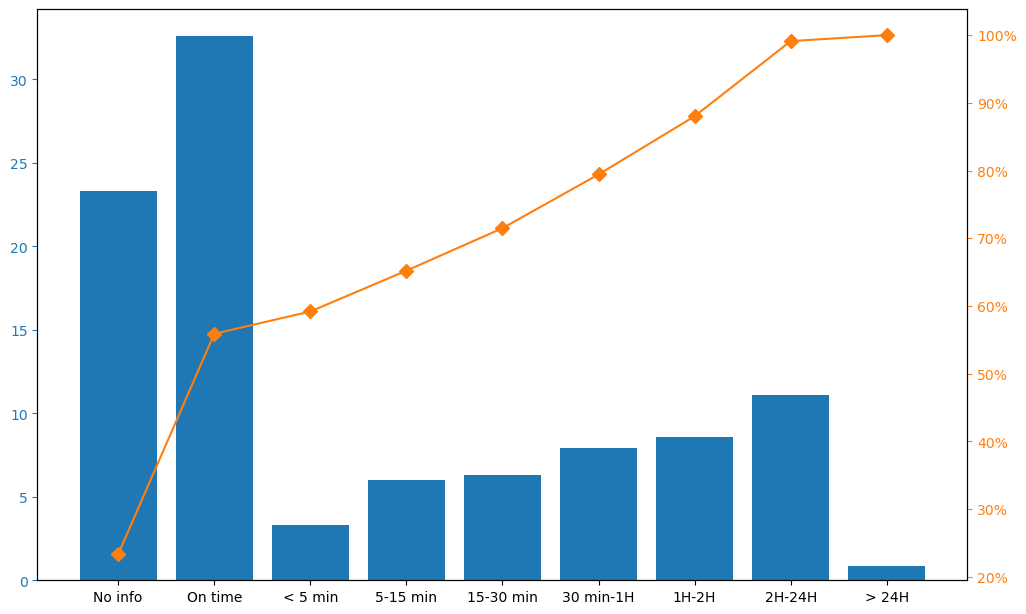

In [28]:
df_tmp = pd.DataFrame({'Delay': [23.29, 32.58, 3.30, 6.03, 6.28, 7.94, 8.60, 11.10, 0.88]})
df_tmp.index = ['No info', 'On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H']
# df_tmp = df_tmp.sort_values(by='Delay',ascending=False)
df_tmp["cum_percent"] = df_tmp["Delay"].cumsum()/df_tmp["Delay"].sum()*100


fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["Delay"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

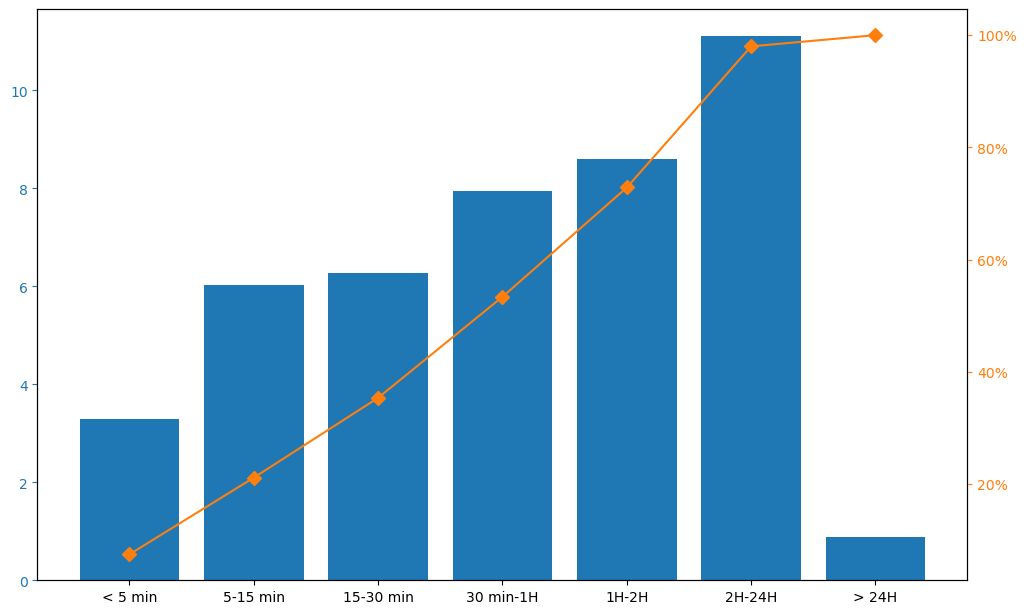

In [29]:
df_tmp = pd.DataFrame({'Delay': [3.30, 6.03, 6.28, 7.94, 8.60, 11.10, 0.88]})
df_tmp.index = ['< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H']
# df_tmp = df_tmp.sort_values(by='Delay',ascending=False)
df_tmp["cum_percent"] = df_tmp["Delay"].cumsum()/df_tmp["Delay"].sum()*100


fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["Delay"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [30]:
categories = pd.cut(df['delay_at_checkout_in_minutes'], 
                    bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
                    labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

df['cat_delay'] = categories

# df.sample(15)
print(f"Returns :")
print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


KeyError: 'delay_at_checkout_in_minutes'

In [ ]:
# categories = pd.cut(df['delay_at_checkout_in_minutes'], 
#                     bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
#                     labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

# df['cat_delay'] = categories

# # df.sample(15)
# print(f"Returns :")
# print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
# print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# categories = pd.cut(df['delay_at_checkout_in_minutes'], 
#                     bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
#                     labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

# df['cat_delay'] = categories

# # df.sample(15)
# print(f"Returns :")
# print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
# print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# df_tmp = quick_View(df)
# print(f"\n\nQuickView :")
# display(df_tmp.sort_values(by="# null", ascending=False))   


In [ ]:
# tmp_df = df[df['delay_at_checkout_in_minutes']>0]

# fig, ax = plt.subplots(figsize=(k_Width,k_Height))
# sns.histplot(data=tmp_df, x="delay_at_checkout_in_minutes", bins=100) #, bins=100, , kde=True, , hue="checkin_type", bins=500
# ax.set_title("Distribution of delay_at_checkout_in_minutes in range [-2_000, +2_000]")
# ax.set_xlabel("Minutes")
# plt.show()

In [ ]:
# len((df_tmp[df_tmp['state']=="ended"]))
# len(df[(df['delay_at_checkout_in_minutes'].notna())])
# len((df[df['delay_at_checkout_in_minutes'].notna()]) & (df[df['state']=="canceled"]))
# len(df[(df['delay_at_checkout_in_minutes'].notna()) & (df[df['state']=="canceled"])       ]) 


In [ ]:
# this is WRONG
# cannot divide by len(df) since we would count ended and canceled while delay ONLY happen on ended returns 
print(f"Late returns         : {round(len(df[df['delay_at_checkout_in_minutes']>0])/len(df)*100, 2)} %")
print(f"On time returns      : {round(len(df[df['delay_at_checkout_in_minutes']<=0])/len(df)*100, 2)} %")
print(f"Returns without info : {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)} %")



In [ ]:
# I don't see how to use a pivot table here since I want to count positives, negatives and Nan    
# ! use len and NOT count(), np.size(), size()
# df_pivot = df_tmp.pivot_table(index='state', columns='consecutive', aggfunc=len, margins=True, margins_name='Total') 
# display(df_pivot)     

n0 = len((df[df['state']=="ended"]))
# print(n0)

n1 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']>0)             ]))
# print(n1)

n2 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']<=0)            ]))
# print(n2)

n3 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes'].isna())        ]))
# print(n3)

data = {
    'Delay': [n1, n2, n3],
    'Ended': ["Late", "On time", "No data"]
}
df_tmp = pd.DataFrame(data)

_ = df_tmp["Delay"].plot.pie(
    title="State of the Delay for ended returns in %", 
    labels=df_tmp["Ended"],
    autopct="%1.1f%%", 
    figsize=(k_Width, k_Height))

print(f"Late returns         : {round(len(df[df['delay_at_checkout_in_minutes'] > 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"On time returns      : {round(len(df[df['delay_at_checkout_in_minutes'] <= 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"Returns without info : {round(len((df[(df['state']=='ended')     &      (df['delay_at_checkout_in_minutes'].isna())        ]))/len(df[df['state'] == 'ended'])*100, 2)} %")




In [ ]:
df_tmp = df[df['state']=="ended"]
display(df_tmp.sample(15))

n = len(df_tmp)
p1 = len(df_tmp[df_tmp['delay_at_checkout_in_minutes'] > 0])    /n * 100
p2 = len(df_tmp[df_tmp['delay_at_checkout_in_minutes'] <= 0])   /n * 100
p3 = len(df_tmp[df_tmp['delay_at_checkout_in_minutes'].isna()]) /n * 100

print(f"Late returns         : {p1:.2f} %")
print(f"On time returns      : {p2:.2f} %")
print(f"Returns without info : {p3:.2f} %")

data = {
    'Delay': [n1, n2, n3],
    'Ended': ["Late", "On time", "No data"]
}
df_tmp = pd.DataFrame(data)

_ = df_tmp["Delay"].plot.pie(
    title="State of the Delay for ended returns in %", 
    labels=df_tmp["Ended"],
    autopct="%1.1f%%", 
    figsize=(k_Width, k_Height))



In [ ]:
# I don't see how to use a pivot table here since I want to count positives, negatives and Nan    
# ! use len and NOT count(), np.size(), size()
# df_pivot = df_tmp.pivot_table(index='state', columns='consecutive', aggfunc=len, margins=True, margins_name='Total') 
# display(df_pivot)     

n0 = len((df[df['state']=="ended"]))
# print(n0)

n1 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']>0)             ]))
# print(n1)

n2 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes']<=0)            ]))
# print(n2)

n3 = len((df[(df['state']=="ended")     &      (df['delay_at_checkout_in_minutes'].isna())        ]))
# print(n3)

data = {
    'Delay': [n1, n2, n3],
    'Ended': ["Late", "On time", "No data"]
}
df_tmp = pd.DataFrame(data)

_ = df_tmp["Delay"].plot.pie(
    title="State of the Delay for ended returns in %", 
    labels=df_tmp["Ended"],
    autopct="%1.1f%%", 
    figsize=(k_Width, k_Height))

print(f"Late returns         : {round(len(df[df['delay_at_checkout_in_minutes'] > 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"On time returns      : {round(len(df[df['delay_at_checkout_in_minutes'] <= 0]) / len(df[df['state'] == 'ended']) * 100, 2)} %")
print(f"Returns without info : {round(len((df[(df['state']=='ended')     &      (df['delay_at_checkout_in_minutes'].isna())        ]))/len(df[df['state'] == 'ended'])*100, 2)} %")




In [ ]:
df_tmp2 = pd.DataFrame(round(df_tmp['cat_delay'].value_counts()/len(df_tmp)*100, 2)).reset_index()
df_tmp2.columns = ['cat_delay', 'delay_%']

df_tmp2['cat_delay'] = pd.Categorical(df_tmp2['cat_delay'], categories=labels_in_order, ordered=True)
df_tmp2.sort_values('cat_delay', inplace=True)
df_tmp2.set_index('cat_delay', inplace=True)
print(df_tmp2)

In [ ]:
df_tmp2["cum_percent"] = df_tmp2["delay_%"].cumsum()/df_tmp2["delay_%"].sum()*100

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp2.index, df_tmp2["delay_%"], color="C0")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Percentage')
ax.tick_params(axis="y", colors="C0")
ax.set_title("Distribution of the returns  & their cumulative sum")

ax2 = ax.twinx()
ax2.plot(df_tmp2.index, df_tmp2["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative sum')
ax2.set(ylim=(0, 110))
ax2.tick_params(axis="y", colors="C1")

plt.show()

In [ ]:
labels_in_order = ['On time', '0-10 min', '10-30 min', '30 min-1H', '1H-2H', '2H-6H', '> 6H']

categories = pd.cut(
    df_tmp['delay_at_checkout_in_minutes'], 
    bins=[-float('inf'), 0, 10, 30, 60, 120, 360, float('inf')],
    labels = labels_in_order
)

# df_tmp is a view NOT a copy this is why the line below may generates a warning
# df_tmp['cat_delay'] = categories
df_tmp.loc[:, "cat_delay"] = categories
# display(df_tmp.sample(15))

print(f"Returns :")
print(f"No info      {round(df_tmp['delay_at_checkout_in_minutes'].isna().sum()/len(df_tmp)*100, 2)}")
print(round(df_tmp['cat_delay'].value_counts()/len(df_tmp)*100, 2))


In [ ]:
# df_tmp = pd.concat([df_tmp, df_tmp2, df_tmp3])
# late_returns = len(df_tmp)


# nb_late_canceled = len(df_tmp[df_tmp['state']=="canceled"])
# nb_late_ended = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] > 0) & (df_tmp['state']=="ended")])              
# nb_ontime_ended = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'] <= 0)           & (df_tmp['state']=="ended")]) 
# nb_nodata_ended = len(df_tmp[(df_tmp['delay_at_checkout_in_minutes'].isna())         & (df_tmp['state']=="ended")]) 
# nb_late = nb_late_canceled+nb_late_ended

# print(f"Late returns         : {nb_late}")
# print(f"On time returns      : {nb_ontime_ended}")
# print(f"Returns without info : {nb_nodata_ended}")

# data = {
#     'Delay': [nb_late, nb_ontime_ended, nb_nodata_ended],
#     'Ended': ["Late", "On time", "No data"]
# }
# df_pie = pd.DataFrame(data)

# _ = df_pie["Delay"].plot.pie(
#     title="State of the delay at checkout in %", 
#     labels=df_pie["Ended"],
#     autopct="%1.1f%%", 
#     figsize=(k_Width, k_Height))



In [ ]:

# TODO : faut être plus fin que ça. 
# Dans les consecutifs on considère late ssi `delay_at_checkout_in_minutes` is strictly greater than ``time_delta_with_previous_rental_in_minutes``
# Faut trouver 270
# voir plus bas

def classify_value(x):
    try:
        value = float(x)
        if value <= 0:
            return "On time"
        elif value > 0:
            return "Late"
        else:
            return "No Data"
    except ValueError:
        return "No Data"

df_tmp = df[["state", "previous_ended_rental_id", "delay_at_checkout_in_minutes"]].copy()
df_tmp.rename(
    columns={
        "previous_ended_rental_id"     : "booking", 
        "delay_at_checkout_in_minutes" : "return",
    }, 
    inplace=True
)
# display(df_tmp.sample(15))
# display(df_tmp.head(15))

df_tmp.loc[pd.notna(df_tmp["booking"]), "booking"] = "consecutive"
df_tmp["booking"].fillna("not consecutive", inplace=True)
# display(df_tmp.head(15))

# convert to string first then replace with meaningful value
df_tmp["return"] = df_tmp["return"].astype(str)
df_tmp['return'] = df_tmp['return'].apply(classify_value)




# # df_pivot = df_tmp.pivot_table(index=['booking', "return"], columns='state', aggfunc=len, margins=True, margins_name='Total')
# # display(df_pivot)


df_pivot = df_tmp.pivot_table(index='state', columns=['booking', "return"], aggfunc=len, margins=True, margins_name='Total')
display(df_pivot)
